ResNetAvgPool1024Extractor

In [1]:
import torch
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import numpy as np

class ResNetAvgPool1024Extractor:
    def __init__(self):
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.eval()
        self.feature = None

        # Hook sul layer avgpool
        def hook_avgpool(module, input, output):
            self.feature = output.squeeze().detach().numpy()

        self.model.avgpool.register_forward_hook(hook_avgpool)

        # Preprocessing: resize, tensor, normalize
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def extract_feature(self, image_path):
        img = Image.open(image_path).convert('RGB')
        input_tensor = self.transform(img).unsqueeze(0)

        with torch.no_grad():
            _ = self.model(input_tensor)

        # self.feature è 2048-dim; riduci a 1024-dim
        avgpool_2048 = self.feature
        avgpool_1024 = 0.5 * (avgpool_2048[::2] + avgpool_2048[1::2])
        return avgpool_1024


# === ESEMPIO USO ===
if __name__ == "__main__":
    image_path = "Part1/brain_glioma/brain_glioma_0001.jpg"  # Sostituisci con il tuo path
    extractor = ResNetAvgPool1024Extractor()
    features = extractor.extract_feature(image_path)

    print("Feature vector (1024 dim):")
    print(features[:10], "...")  # stampa i primi 10 valori

Feature vector (1024 dim):
[0.04737501 0.02057164 0.00852441 0.04339483 0.         0.2076263
 0.12681223 0.0109101  0.         0.        ] ...


task 2

In [5]:
import torch
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import numpy as np
import os
import pandas as pd

class ResNetAvgPool1024Extractor:
    def __init__(self):
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.eval()
        self.feature = None

        # Hook sul layer avgpool
        def hook_avgpool(module, input, output):
            self.feature = output.squeeze().detach().numpy()

        self.model.avgpool.register_forward_hook(hook_avgpool)

        # Preprocessing: resize, tensor, normalize
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def extract_feature(self, image_path):
        img = Image.open(image_path).convert('RGB')
        input_tensor = self.transform(img).unsqueeze(0)

        with torch.no_grad():
            _ = self.model(input_tensor)

        # self.feature è 2048-dim; riduci a 1024-dim
        avgpool_2048 = self.feature
        avgpool_1024 = 0.5 * (avgpool_2048[::2] + avgpool_2048[1::2])
        return avgpool_1024

"""""
def process_folders(base_folder, subfolders):
    extractor = ResNetAvgPool1024Extractor()
    data = []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        print(f"[INFO] Elaboro cartella: {folder_path}")

        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif')):
                image_path = os.path.join(folder_path, filename)
                try:
                    features = extractor.extract_feature(image_path)
                    entry = {
                        "filename": filename,
                        "label": label,
                        **{f"f{i}": features[i] for i in range(len(features))}
                    }
                    data.append(entry)
                except Exception as e:
                    print(f"[ERRORE] Immagine saltata {filename}: {e}")

    return pd.DataFrame(data)


# === ESECUZIONE ===
if __name__ == "__main__":
    base_folder = "Part1"
    subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]

    df = process_folders(base_folder, subfolders)
    df.to_csv("resnet1024_features.csv", index=False)

    print(f"[FINE] Salvato CSV con {len(df)} righe in 'resnet1024_features.csv'")
"""

# === Funzione per elaborare immagini in più cartelle ===
def process_and_save_features(base_folder, subfolders, output_file):
    extractor = ResNetAvgPool1024Extractor()
    all_features = []
    all_filenames = []
    all_labels = []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        print(f"[INFO] Elaboro cartella: {label}")
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extractor.extract_feature(img_path)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)

    # Converti in array
    features_array = np.array(all_features)
    filenames_array = np.array(all_filenames)
    labels_array = np.array(all_labels)

    # Salva in .npz
    np.savez(output_file, features=features_array, filenames=filenames_array, labels=labels_array)
    print(f"[SALVATO] Features salvate in {output_file}")
    print(f"[FINE] Totale immagini processate: {len(all_features)}")


# === Esecuzione ===
base_folder = "Part1"
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]
output_file = "resnet1024.npz"

process_and_save_features(base_folder, subfolders, output_file)

[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in resnet1024.npz
[FINE] Totale immagini processate: 3006



Top 5 simili a Part1/brain_glioma/brain_glioma_0005.jpg (Euclidean & Cosine):
1. brain_glioma_0005.jpg | Classe: brain_glioma | Euclid: 0.0000 | Cosine: 0.0000
2. brain_glioma_0071.jpg | Classe: brain_glioma | Euclid: 2.1480 | Cosine: 0.0366
3. brain_glioma_0258.jpg | Classe: brain_glioma | Euclid: 2.2868 | Cosine: 0.0413
4. brain_glioma_0311.jpg | Classe: brain_glioma | Euclid: 2.4746 | Cosine: 0.0460
5. brain_glioma_0717.jpg | Classe: brain_glioma | Euclid: 3.2342 | Cosine: 0.0846


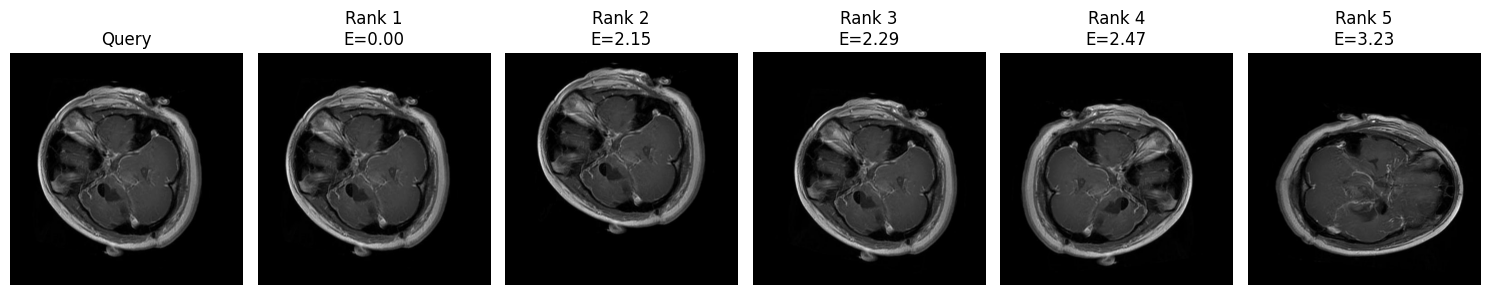


Top 5 simili (Mahalanobis) a Part1/brain_glioma/brain_glioma_0005.jpg:
1. brain_glioma_0005.jpg | Classe: brain_glioma | Distanza: 0.00
2. brain_glioma_0071.jpg | Classe: brain_glioma | Distanza: 30.94
3. brain_glioma_0258.jpg | Classe: brain_glioma | Distanza: 31.58
4. brain_glioma_0311.jpg | Classe: brain_glioma | Distanza: 33.31
5. brain_menin_0578.jpg | Classe: brain_menin | Distanza: 34.19


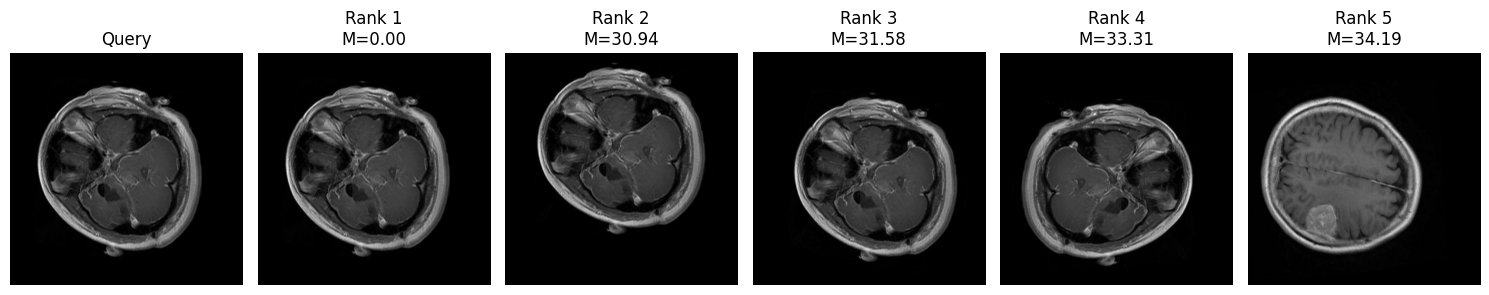

In [6]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from scipy.spatial.distance import mahalanobis
from PIL import Image
import torch
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

# === Estrazione feature con ResNet50 + avgpool 1024 ===
class ResNetAvgPool1024Extractor:
    def __init__(self):
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.eval()
        self.feature = None

        def hook_avgpool(module, input, output):
            self.feature = output.squeeze().detach().numpy()
        
        self.model.avgpool.register_forward_hook(hook_avgpool)

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def extract_feature(self, image_path):
        img = Image.open(image_path).convert('RGB')
        input_tensor = self.transform(img).unsqueeze(0)

        with torch.no_grad():
            _ = self.model(input_tensor)

        feat_2048 = self.feature
        feat_1024 = 0.5 * (feat_2048[::2] + feat_2048[1::2])
        return feat_1024

# === Carica feature ===
data = np.load("resnet1024.npz", allow_pickle=True)
feature_matrix = data["features"]
filenames = data["filenames"]
labels = data["labels"]

extractor = ResNetAvgPool1024Extractor()

# === Trova immagini simili (euclidea e coseno) ===
def find_k_similar(img_path, k):
    query_feature = extractor.extract_feature(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature).reshape(1, -1)

    dist_euc = euclidean_distances(feature_matrix, query_feature).flatten()
    dist_cos = cosine_distances(feature_matrix, query_feature).flatten()

    top_k_idx = np.argsort(dist_euc)[:k]  # puoi usare dist_cos per classifica diversa
    print(f"\nTop {k} simili a {img_path} (Euclidean & Cosine):")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank+1}. {filenames[idx]} | Classe: {labels[idx]} | "
              f"Euclid: {dist_euc[idx]:.4f} | Cosine: {dist_cos[idx]:.4f}")

    fig, axs = plt.subplots(1, k + 1, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        match_img = cv2.imread(os.path.join("Part1", labels[idx], filenames[idx]))
        axs[i + 1].imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        axs[i + 1].set_title(f"Rank {i+1}\nE={dist_euc[idx]:.2f}")
        axs[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

# === Trova immagini simili (Mahalanobis) ===
def find_k_similar_mahalanobis(img_path, k):
    query_feature = extractor.extract_feature(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature)

    cov = np.cov(feature_matrix.T)
    try:
        cov_inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        print("[ERRORE] Matrice di covarianza non invertibile. Uso pseudoinversa.")
        cov_inv = np.linalg.pinv(cov)

    distances = np.array([
        mahalanobis(query_feature, f, cov_inv)
        for f in feature_matrix
    ])

    top_k_idx = np.argsort(distances)[:k]
    print(f"\nTop {k} simili (Mahalanobis) a {img_path}:")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank+1}. {filenames[idx]} | Classe: {labels[idx]} | Distanza: {distances[idx]:.2f}")

    fig, axs = plt.subplots(1, k + 1, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        match_img = cv2.imread(os.path.join("Part1", labels[idx], filenames[idx]))
        axs[i + 1].imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        axs[i + 1].set_title(f"Rank {i+1}\nM={distances[idx]:.2f}")
        axs[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

# === Test ===
query_img = "Part1/brain_glioma/brain_glioma_0005.jpg"
find_k_similar(query_img, k=5)
find_k_similar_mahalanobis(query_img, k=5)